In [1]:
import numpy as np
import math
import random

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torch.multiprocessing as mp
from datetime import datetime

import pdb

from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

# Utils
import data_generator

import classical_newsvendor_utils


from os import listdir
from os.path import isfile, join

In [2]:
is_cuda = False
dev = torch.device('cpu')  
if torch.cuda.is_available():
    is_cuda = True
    dev = torch.device('cuda')  

In [3]:
# Setting the seeds to allow replication
# Changing the seed might require hyperparameter tuning again
# Because it changes the deterministic parameters
seed_number = 42
np.random.seed(seed_number)
torch.manual_seed(seed_number)
random.seed(seed_number)

In [4]:
noise_type = 'multimodal'

In [5]:
N_test = 3000

X, y = data_generator.data_1to1(N_test, noise_level=1, noise_type=noise_type)

X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

In [21]:
for k in [1.0, 10.0, 50.0, 100.0, 300.0, 1000.0]:
    !source /home/alan/Desktop/envs/pao_env/bin/activate && python3 classic_newsvendor.py {k} 2.0

------------------EPOCH 1------------------
DATA LOSS 	 train 6.92 valid 5.57
KL LOSS 	 train 4.6 valid 4.44
ELBO LOSS 	 train 11.53 valid 10.01
------------------EPOCH 2------------------
DATA LOSS 	 train 5.94 valid 5.57
KL LOSS 	 train 4.28 valid 4.11
ELBO LOSS 	 train 10.22 valid 9.68
------------------EPOCH 3------------------
DATA LOSS 	 train 5.91 valid 5.47
KL LOSS 	 train 3.96 valid 3.82
ELBO LOSS 	 train 9.87 valid 9.29
------------------EPOCH 4------------------
DATA LOSS 	 train 5.87 valid 5.45
KL LOSS 	 train 3.68 valid 3.55
ELBO LOSS 	 train 9.56 valid 9.0
------------------EPOCH 5------------------
DATA LOSS 	 train 5.85 valid 5.42
KL LOSS 	 train 3.44 valid 3.33
ELBO LOSS 	 train 9.29 valid 8.75
------------------EPOCH 6------------------
DATA LOSS 	 train 5.83 valid 5.4
KL LOSS 	 train 3.24 valid 3.15
ELBO LOSS 	 train 9.07 valid 8.55
------------------EPOCH 7------------------
DATA LOSS 	 train 5.81 valid 5.36
KL LOSS 	 train 3.08 valid 3.01
ELBO LOSS 	 train 8.89 val

DATA LOSS 	 train 5.64 valid 5.16
KL LOSS 	 train 1.16 valid 1.15
ELBO LOSS 	 train 6.79 valid 6.31
------------------EPOCH 59------------------
DATA LOSS 	 train 5.63 valid 5.17
KL LOSS 	 train 1.13 valid 1.12
ELBO LOSS 	 train 6.76 valid 6.29
------------------EPOCH 60------------------
DATA LOSS 	 train 5.64 valid 5.16
KL LOSS 	 train 1.11 valid 1.1
ELBO LOSS 	 train 6.75 valid 6.26
------------------EPOCH 61------------------
DATA LOSS 	 train 5.63 valid 5.16
KL LOSS 	 train 1.09 valid 1.08
ELBO LOSS 	 train 6.72 valid 6.25
------------------EPOCH 62------------------
DATA LOSS 	 train 5.63 valid 5.16
KL LOSS 	 train 1.07 valid 1.06
ELBO LOSS 	 train 6.71 valid 6.22
------------------EPOCH 63------------------
DATA LOSS 	 train 5.63 valid 5.16
KL LOSS 	 train 1.05 valid 1.04
ELBO LOSS 	 train 6.68 valid 6.2
------------------EPOCH 64------------------
DATA LOSS 	 train 5.63 valid 5.16
KL LOSS 	 train 1.03 valid 1.02
ELBO LOSS 	 train 6.66 valid 6.18
------------------EPOCH 65------

DATA LOSS 	 train 5.73 valid 5.21
KL LOSS 	 train 16.59 valid 16.34
ELBO LOSS 	 train 22.32 valid 21.55
------------------EPOCH 16------------------
DATA LOSS 	 train 5.72 valid 5.23
KL LOSS 	 train 16.08 valid 15.85
ELBO LOSS 	 train 21.8 valid 21.08
------------------EPOCH 17------------------
DATA LOSS 	 train 5.72 valid 5.22
KL LOSS 	 train 15.59 valid 15.36
ELBO LOSS 	 train 21.3 valid 20.58
------------------EPOCH 18------------------
DATA LOSS 	 train 5.71 valid 5.23
KL LOSS 	 train 15.11 valid 14.88
ELBO LOSS 	 train 20.82 valid 20.11
------------------EPOCH 19------------------
DATA LOSS 	 train 5.7 valid 5.21
KL LOSS 	 train 14.65 valid 14.44
ELBO LOSS 	 train 20.35 valid 19.66
------------------EPOCH 20------------------
DATA LOSS 	 train 5.71 valid 5.21
KL LOSS 	 train 14.22 valid 14.0
ELBO LOSS 	 train 19.93 valid 19.21
------------------EPOCH 21------------------
DATA LOSS 	 train 5.71 valid 5.22
KL LOSS 	 train 13.81 valid 13.58
ELBO LOSS 	 train 19.52 valid 18.8
-------

DATA LOSS 	 train 5.62 valid 5.15
KL LOSS 	 train 4.85 valid 4.8
ELBO LOSS 	 train 10.47 valid 9.96
------------------EPOCH 72------------------
DATA LOSS 	 train 5.62 valid 5.14
KL LOSS 	 train 4.78 valid 4.76
ELBO LOSS 	 train 10.4 valid 9.9
------------------EPOCH 73------------------
DATA LOSS 	 train 5.63 valid 5.14
KL LOSS 	 train 4.71 valid 4.69
ELBO LOSS 	 train 10.35 valid 9.83
------------------EPOCH 74------------------
DATA LOSS 	 train 5.65 valid 5.15
KL LOSS 	 train 4.65 valid 4.62
ELBO LOSS 	 train 10.3 valid 9.77
------------------EPOCH 75------------------
DATA LOSS 	 train 5.62 valid 5.15
KL LOSS 	 train 4.58 valid 4.55
ELBO LOSS 	 train 10.2 valid 9.71
------------------EPOCH 76------------------
DATA LOSS 	 train 5.63 valid 5.15
KL LOSS 	 train 4.52 valid 4.49
ELBO LOSS 	 train 10.15 valid 9.64
------------------EPOCH 77------------------
DATA LOSS 	 train 5.62 valid 5.15
KL LOSS 	 train 4.46 valid 4.43
ELBO LOSS 	 train 10.08 valid 9.58
------------------EPOCH 78--

DATA LOSS 	 train 5.68 valid 5.25
KL LOSS 	 train 32.88 valid 32.32
ELBO LOSS 	 train 38.56 valid 37.57
------------------EPOCH 28------------------
DATA LOSS 	 train 5.68 valid 5.25
KL LOSS 	 train 31.9 valid 31.54
ELBO LOSS 	 train 37.58 valid 36.78
------------------EPOCH 29------------------
DATA LOSS 	 train 5.68 valid 5.21
KL LOSS 	 train 31.0 valid 30.51
ELBO LOSS 	 train 36.67 valid 35.72
------------------EPOCH 30------------------
DATA LOSS 	 train 5.67 valid 5.21
KL LOSS 	 train 30.1 valid 29.61
ELBO LOSS 	 train 35.77 valid 34.81
------------------EPOCH 31------------------
DATA LOSS 	 train 5.67 valid 5.22
KL LOSS 	 train 29.27 valid 28.95
ELBO LOSS 	 train 34.94 valid 34.17
------------------EPOCH 32------------------
DATA LOSS 	 train 5.67 valid 5.21
KL LOSS 	 train 28.47 valid 28.08
ELBO LOSS 	 train 34.15 valid 33.29
------------------EPOCH 33------------------
DATA LOSS 	 train 5.66 valid 5.22
KL LOSS 	 train 27.73 valid 27.27
ELBO LOSS 	 train 33.39 valid 32.49
-----

DATA LOSS 	 train 5.62 valid 5.16
KL LOSS 	 train 12.86 valid 12.81
ELBO LOSS 	 train 18.48 valid 17.97
------------------EPOCH 84------------------
DATA LOSS 	 train 5.64 valid 5.16
KL LOSS 	 train 12.71 valid 12.62
ELBO LOSS 	 train 18.35 valid 17.78
------------------EPOCH 85------------------
DATA LOSS 	 train 5.65 valid 5.17
KL LOSS 	 train 12.6 valid 12.57
ELBO LOSS 	 train 18.25 valid 17.74
------------------EPOCH 86------------------
DATA LOSS 	 train 5.62 valid 5.15
KL LOSS 	 train 12.48 valid 12.3
ELBO LOSS 	 train 18.1 valid 17.45
------------------EPOCH 87------------------
DATA LOSS 	 train 5.62 valid 5.14
KL LOSS 	 train 12.35 valid 12.28
ELBO LOSS 	 train 17.98 valid 17.42
------------------EPOCH 88------------------
DATA LOSS 	 train 5.62 valid 5.15
KL LOSS 	 train 12.25 valid 12.18
ELBO LOSS 	 train 17.87 valid 17.33
------------------EPOCH 89------------------
DATA LOSS 	 train 5.63 valid 5.15
KL LOSS 	 train 12.15 valid 12.1
ELBO LOSS 	 train 17.78 valid 17.25
------

DATA LOSS 	 train 5.67 valid 5.18
KL LOSS 	 train 37.2 valid 36.66
ELBO LOSS 	 train 42.87 valid 41.85
------------------EPOCH 39------------------
DATA LOSS 	 train 5.65 valid 5.18
KL LOSS 	 train 36.43 valid 36.04
ELBO LOSS 	 train 42.09 valid 41.22
------------------EPOCH 40------------------
DATA LOSS 	 train 5.67 valid 5.23
KL LOSS 	 train 35.65 valid 35.25
ELBO LOSS 	 train 41.32 valid 40.48
------------------EPOCH 41------------------
DATA LOSS 	 train 5.68 valid 5.24
KL LOSS 	 train 34.92 valid 34.64
ELBO LOSS 	 train 40.59 valid 39.88
------------------EPOCH 42------------------
DATA LOSS 	 train 5.67 valid 5.21
KL LOSS 	 train 34.22 valid 33.99
ELBO LOSS 	 train 39.9 valid 39.19
------------------EPOCH 43------------------
DATA LOSS 	 train 5.68 valid 5.18
KL LOSS 	 train 33.64 valid 33.26
ELBO LOSS 	 train 39.32 valid 38.44
------------------EPOCH 44------------------
DATA LOSS 	 train 5.65 valid 5.21
KL LOSS 	 train 33.04 valid 32.58
ELBO LOSS 	 train 38.69 valid 37.79
----

DATA LOSS 	 train 5.63 valid 5.16
KL LOSS 	 train 19.08 valid 19.09
ELBO LOSS 	 train 24.71 valid 24.25
------------------EPOCH 95------------------
DATA LOSS 	 train 5.63 valid 5.18
KL LOSS 	 train 18.98 valid 18.87
ELBO LOSS 	 train 24.61 valid 24.05
------------------EPOCH 96------------------
DATA LOSS 	 train 5.63 valid 5.18
KL LOSS 	 train 18.87 valid 18.72
ELBO LOSS 	 train 24.49 valid 23.9
------------------EPOCH 97------------------
DATA LOSS 	 train 5.64 valid 5.15
KL LOSS 	 train 18.81 valid 18.67
ELBO LOSS 	 train 24.45 valid 23.82
------------------EPOCH 98------------------
DATA LOSS 	 train 5.64 valid 5.15
KL LOSS 	 train 18.69 valid 18.59
ELBO LOSS 	 train 24.33 valid 23.74
------------------EPOCH 99------------------
DATA LOSS 	 train 5.63 valid 5.17
KL LOSS 	 train 18.55 valid 18.42
ELBO LOSS 	 train 24.18 valid 23.6
------------------EPOCH 100------------------
DATA LOSS 	 train 5.63 valid 5.15
KL LOSS 	 train 18.46 valid 18.46
ELBO LOSS 	 train 24.09 valid 23.61
---

DATA LOSS 	 train 5.69 valid 5.18
KL LOSS 	 train 56.27 valid 56.23
ELBO LOSS 	 train 61.96 valid 61.41
------------------EPOCH 50------------------
DATA LOSS 	 train 5.68 valid 5.21
KL LOSS 	 train 55.51 valid 54.83
ELBO LOSS 	 train 61.19 valid 60.04
------------------EPOCH 51------------------
DATA LOSS 	 train 5.71 valid 5.18
KL LOSS 	 train 54.79 valid 54.21
ELBO LOSS 	 train 60.5 valid 59.39
------------------EPOCH 52------------------
DATA LOSS 	 train 5.68 valid 5.17
KL LOSS 	 train 54.21 valid 53.73
ELBO LOSS 	 train 59.9 valid 58.9
------------------EPOCH 53------------------
DATA LOSS 	 train 5.66 valid 5.19
KL LOSS 	 train 53.5 valid 52.79
ELBO LOSS 	 train 59.17 valid 57.98
------------------EPOCH 54------------------
DATA LOSS 	 train 5.66 valid 5.19
KL LOSS 	 train 52.67 valid 52.3
ELBO LOSS 	 train 58.34 valid 57.48
------------------EPOCH 55------------------
DATA LOSS 	 train 5.66 valid 5.18
KL LOSS 	 train 51.94 valid 51.49
ELBO LOSS 	 train 57.61 valid 56.66
-------

DATA LOSS 	 train 5.9 valid 5.51
KL LOSS 	 train 2260.95 valid 1947.53
ELBO LOSS 	 train 2266.86 valid 1953.04
------------------EPOCH 5------------------
DATA LOSS 	 train 5.92 valid 5.57
KL LOSS 	 train 1674.23 valid 1422.03
ELBO LOSS 	 train 1680.15 valid 1427.6
------------------EPOCH 6------------------
DATA LOSS 	 train 5.93 valid 5.5
KL LOSS 	 train 1219.06 valid 1037.48
ELBO LOSS 	 train 1224.99 valid 1042.99
------------------EPOCH 7------------------
DATA LOSS 	 train 5.94 valid 5.49
KL LOSS 	 train 900.35 valid 775.81
ELBO LOSS 	 train 906.29 valid 781.3
------------------EPOCH 8------------------
DATA LOSS 	 train 5.94 valid 5.53
KL LOSS 	 train 688.67 valid 613.65
ELBO LOSS 	 train 694.61 valid 619.18
------------------EPOCH 9------------------
DATA LOSS 	 train 5.93 valid 5.43
KL LOSS 	 train 552.71 valid 502.62
ELBO LOSS 	 train 558.64 valid 508.05
------------------EPOCH 10------------------
DATA LOSS 	 train 5.94 valid 5.61
KL LOSS 	 train 464.12 valid 430.14
ELBO LOSS

DATA LOSS 	 train 5.75 valid 5.29
KL LOSS 	 train 107.63 valid 108.02
ELBO LOSS 	 train 113.38 valid 113.31
------------------EPOCH 59------------------
DATA LOSS 	 train 5.74 valid 5.31
KL LOSS 	 train 106.75 valid 105.57
ELBO LOSS 	 train 112.49 valid 110.88
------------------EPOCH 60------------------
DATA LOSS 	 train 5.74 valid 5.23
KL LOSS 	 train 106.01 valid 106.1
ELBO LOSS 	 train 111.76 valid 111.33
------------------EPOCH 61------------------
DATA LOSS 	 train 5.72 valid 5.29
KL LOSS 	 train 105.36 valid 104.75
ELBO LOSS 	 train 111.09 valid 110.04
------------------EPOCH 62------------------
DATA LOSS 	 train 5.78 valid 5.27
KL LOSS 	 train 104.59 valid 104.83
ELBO LOSS 	 train 110.37 valid 110.1
------------------EPOCH 63------------------
DATA LOSS 	 train 5.73 valid 5.25
KL LOSS 	 train 104.08 valid 103.34
ELBO LOSS 	 train 109.81 valid 108.59
------------------EPOCH 64------------------
DATA LOSS 	 train 5.77 valid 5.24
KL LOSS 	 train 103.53 valid 103.08
ELBO LOSS 	 tr

In [22]:
for eps in [0.0, 0.1, 1.0, 5.0, 10.0, 30.0]:
    !source /home/alan/Desktop/envs/pao_env/bin/activate && python3 classic_newsvendor.py {eps}

------------------EPOCH 1------------------
DATA LOSS 	 train 6.62 valid 5.83
KL LOSS 	 train 0.0 valid 0
ELBO LOSS 	 train 6.62 valid 5.83
------------------EPOCH 2------------------
DATA LOSS 	 train 6.11 valid 5.7
KL LOSS 	 train 0.0 valid 0
ELBO LOSS 	 train 6.11 valid 5.7
------------------EPOCH 3------------------
DATA LOSS 	 train 6.08 valid 5.58
KL LOSS 	 train 0.0 valid 0
ELBO LOSS 	 train 6.08 valid 5.58
------------------EPOCH 4------------------
DATA LOSS 	 train 6.07 valid 5.47
KL LOSS 	 train 0.0 valid 0
ELBO LOSS 	 train 6.07 valid 5.47
------------------EPOCH 5------------------
DATA LOSS 	 train 6.05 valid 5.38
KL LOSS 	 train 0.0 valid 0
ELBO LOSS 	 train 6.05 valid 5.38
------------------EPOCH 6------------------
DATA LOSS 	 train 6.02 valid 5.37
KL LOSS 	 train 0.0 valid 0
ELBO LOSS 	 train 6.02 valid 5.37
------------------EPOCH 7------------------
DATA LOSS 	 train 5.97 valid 5.41
KL LOSS 	 train 0.0 valid 0
ELBO LOSS 	 train 5.97 valid 5.41
------------------EPOC

DATA LOSS 	 train 5.68 valid 5.19
KL LOSS 	 train 0.0 valid 0
ELBO LOSS 	 train 5.68 valid 5.19
------------------EPOCH 61------------------
DATA LOSS 	 train 5.68 valid 5.2
KL LOSS 	 train 0.0 valid 0
ELBO LOSS 	 train 5.68 valid 5.2
------------------EPOCH 62------------------
DATA LOSS 	 train 5.67 valid 5.18
KL LOSS 	 train 0.0 valid 0
ELBO LOSS 	 train 5.67 valid 5.18
------------------EPOCH 63------------------
DATA LOSS 	 train 5.68 valid 5.18
KL LOSS 	 train 0.0 valid 0
ELBO LOSS 	 train 5.68 valid 5.18
------------------EPOCH 64------------------
DATA LOSS 	 train 5.67 valid 5.18
KL LOSS 	 train 0.0 valid 0
ELBO LOSS 	 train 5.67 valid 5.18
------------------EPOCH 65------------------
DATA LOSS 	 train 5.67 valid 5.18
KL LOSS 	 train 0.0 valid 0
ELBO LOSS 	 train 5.67 valid 5.18
------------------EPOCH 66------------------
DATA LOSS 	 train 5.67 valid 5.18
KL LOSS 	 train 0.0 valid 0
ELBO LOSS 	 train 5.67 valid 5.18
------------------EPOCH 67------------------
DATA LOSS 	 tra

DATA LOSS 	 train 5.82 valid 5.51
KL LOSS 	 train 0.0 valid 0
ELBO LOSS 	 train 5.82 valid 5.51
------------------EPOCH 20------------------
DATA LOSS 	 train 5.81 valid 5.49
KL LOSS 	 train 0.0 valid 0
ELBO LOSS 	 train 5.81 valid 5.49
------------------EPOCH 21------------------
DATA LOSS 	 train 5.8 valid 5.46
KL LOSS 	 train 0.0 valid 0
ELBO LOSS 	 train 5.8 valid 5.46
------------------EPOCH 22------------------
DATA LOSS 	 train 5.79 valid 5.44
KL LOSS 	 train 0.0 valid 0
ELBO LOSS 	 train 5.79 valid 5.44
------------------EPOCH 23------------------
DATA LOSS 	 train 5.78 valid 5.42
KL LOSS 	 train 0.0 valid 0
ELBO LOSS 	 train 5.78 valid 5.42
------------------EPOCH 24------------------
DATA LOSS 	 train 5.77 valid 5.4
KL LOSS 	 train 0.0 valid 0
ELBO LOSS 	 train 5.77 valid 5.4
------------------EPOCH 25------------------
DATA LOSS 	 train 5.76 valid 5.38
KL LOSS 	 train 0.0 valid 0
ELBO LOSS 	 train 5.76 valid 5.38
------------------EPOCH 26------------------
DATA LOSS 	 train

DATA LOSS 	 train 5.66 valid 5.18
KL LOSS 	 train 0.0 valid 0
ELBO LOSS 	 train 5.66 valid 5.18
------------------EPOCH 79------------------
DATA LOSS 	 train 5.66 valid 5.18
KL LOSS 	 train 0.0 valid 0
ELBO LOSS 	 train 5.66 valid 5.18
------------------EPOCH 80------------------
DATA LOSS 	 train 5.66 valid 5.18
KL LOSS 	 train 0.0 valid 0
ELBO LOSS 	 train 5.66 valid 5.18
------------------EPOCH 81------------------
DATA LOSS 	 train 5.66 valid 5.18
KL LOSS 	 train 0.0 valid 0
ELBO LOSS 	 train 5.66 valid 5.18
------------------EPOCH 82------------------
DATA LOSS 	 train 5.66 valid 5.17
KL LOSS 	 train 0.0 valid 0
ELBO LOSS 	 train 5.66 valid 5.17
------------------EPOCH 83------------------
DATA LOSS 	 train 5.66 valid 5.17
KL LOSS 	 train 0.0 valid 0
ELBO LOSS 	 train 5.66 valid 5.17
------------------EPOCH 84------------------
DATA LOSS 	 train 5.66 valid 5.17
KL LOSS 	 train 0.0 valid 0
ELBO LOSS 	 train 5.66 valid 5.17
------------------EPOCH 85------------------
DATA LOSS 	 t

DATA LOSS 	 train 5.72 valid 5.25
KL LOSS 	 train 0.0 valid 0
ELBO LOSS 	 train 5.72 valid 5.25
------------------EPOCH 38------------------
DATA LOSS 	 train 5.71 valid 5.25
KL LOSS 	 train 0.0 valid 0
ELBO LOSS 	 train 5.71 valid 5.25
------------------EPOCH 39------------------
DATA LOSS 	 train 5.71 valid 5.25
KL LOSS 	 train 0.0 valid 0
ELBO LOSS 	 train 5.71 valid 5.25
------------------EPOCH 40------------------
DATA LOSS 	 train 5.71 valid 5.24
KL LOSS 	 train 0.0 valid 0
ELBO LOSS 	 train 5.71 valid 5.24
------------------EPOCH 41------------------
DATA LOSS 	 train 5.71 valid 5.24
KL LOSS 	 train 0.0 valid 0
ELBO LOSS 	 train 5.71 valid 5.24
------------------EPOCH 42------------------
DATA LOSS 	 train 5.71 valid 5.23
KL LOSS 	 train 0.0 valid 0
ELBO LOSS 	 train 5.71 valid 5.23
------------------EPOCH 43------------------
DATA LOSS 	 train 5.7 valid 5.23
KL LOSS 	 train 0.0 valid 0
ELBO LOSS 	 train 5.7 valid 5.23
------------------EPOCH 44------------------
DATA LOSS 	 tra

DATA LOSS 	 train 5.65 valid 5.17
KL LOSS 	 train 0.0 valid 0
ELBO LOSS 	 train 5.65 valid 5.17
------------------EPOCH 97------------------
DATA LOSS 	 train 5.64 valid 5.16
KL LOSS 	 train 0.0 valid 0
ELBO LOSS 	 train 5.64 valid 5.16
------------------EPOCH 98------------------
DATA LOSS 	 train 5.64 valid 5.16
KL LOSS 	 train 0.0 valid 0
ELBO LOSS 	 train 5.64 valid 5.16
------------------EPOCH 99------------------
DATA LOSS 	 train 5.64 valid 5.16
KL LOSS 	 train 0.0 valid 0
ELBO LOSS 	 train 5.64 valid 5.16
------------------EPOCH 100------------------
DATA LOSS 	 train 5.64 valid 5.16
KL LOSS 	 train 0.0 valid 0
ELBO LOSS 	 train 5.64 valid 5.16
------------------EPOCH 1------------------
DATA LOSS 	 train 6.62 valid 5.83
KL LOSS 	 train 0.0 valid 0
ELBO LOSS 	 train 6.62 valid 5.83
------------------EPOCH 2------------------
DATA LOSS 	 train 6.11 valid 5.7
KL LOSS 	 train 0.0 valid 0
ELBO LOSS 	 train 6.11 valid 5.7
------------------EPOCH 3------------------
DATA LOSS 	 train

DATA LOSS 	 train 5.69 valid 5.19
KL LOSS 	 train 0.0 valid 0
ELBO LOSS 	 train 5.69 valid 5.19
------------------EPOCH 56------------------
DATA LOSS 	 train 5.68 valid 5.19
KL LOSS 	 train 0.0 valid 0
ELBO LOSS 	 train 5.68 valid 5.19
------------------EPOCH 57------------------
DATA LOSS 	 train 5.68 valid 5.19
KL LOSS 	 train 0.0 valid 0
ELBO LOSS 	 train 5.68 valid 5.19
------------------EPOCH 58------------------
DATA LOSS 	 train 5.68 valid 5.19
KL LOSS 	 train 0.0 valid 0
ELBO LOSS 	 train 5.68 valid 5.19
------------------EPOCH 59------------------
DATA LOSS 	 train 5.68 valid 5.19
KL LOSS 	 train 0.0 valid 0
ELBO LOSS 	 train 5.68 valid 5.19
------------------EPOCH 60------------------
DATA LOSS 	 train 5.68 valid 5.19
KL LOSS 	 train 0.0 valid 0
ELBO LOSS 	 train 5.68 valid 5.19
------------------EPOCH 61------------------
DATA LOSS 	 train 5.68 valid 5.2
KL LOSS 	 train 0.0 valid 0
ELBO LOSS 	 train 5.68 valid 5.2
------------------EPOCH 62------------------
DATA LOSS 	 tra

DATA LOSS 	 train 5.86 valid 5.56
KL LOSS 	 train 0.0 valid 0
ELBO LOSS 	 train 5.86 valid 5.56
------------------EPOCH 15------------------
DATA LOSS 	 train 5.86 valid 5.62
KL LOSS 	 train 0.0 valid 0
ELBO LOSS 	 train 5.86 valid 5.62
------------------EPOCH 16------------------
DATA LOSS 	 train 5.86 valid 5.6
KL LOSS 	 train 0.0 valid 0
ELBO LOSS 	 train 5.86 valid 5.6
------------------EPOCH 17------------------
DATA LOSS 	 train 5.85 valid 5.56
KL LOSS 	 train 0.0 valid 0
ELBO LOSS 	 train 5.85 valid 5.56
------------------EPOCH 18------------------
DATA LOSS 	 train 5.83 valid 5.54
KL LOSS 	 train 0.0 valid 0
ELBO LOSS 	 train 5.83 valid 5.54
------------------EPOCH 19------------------
DATA LOSS 	 train 5.82 valid 5.51
KL LOSS 	 train 0.0 valid 0
ELBO LOSS 	 train 5.82 valid 5.51
------------------EPOCH 20------------------
DATA LOSS 	 train 5.81 valid 5.49
KL LOSS 	 train 0.0 valid 0
ELBO LOSS 	 train 5.81 valid 5.49
------------------EPOCH 21------------------
DATA LOSS 	 tra

DATA LOSS 	 train 5.67 valid 5.18
KL LOSS 	 train 0.0 valid 0
ELBO LOSS 	 train 5.67 valid 5.18
------------------EPOCH 74------------------
DATA LOSS 	 train 5.66 valid 5.18
KL LOSS 	 train 0.0 valid 0
ELBO LOSS 	 train 5.66 valid 5.18
------------------EPOCH 75------------------
DATA LOSS 	 train 5.66 valid 5.18
KL LOSS 	 train 0.0 valid 0
ELBO LOSS 	 train 5.66 valid 5.18
------------------EPOCH 76------------------
DATA LOSS 	 train 5.66 valid 5.18
KL LOSS 	 train 0.0 valid 0
ELBO LOSS 	 train 5.66 valid 5.18
------------------EPOCH 77------------------
DATA LOSS 	 train 5.66 valid 5.18
KL LOSS 	 train 0.0 valid 0
ELBO LOSS 	 train 5.66 valid 5.18
------------------EPOCH 78------------------
DATA LOSS 	 train 5.66 valid 5.18
KL LOSS 	 train 0.0 valid 0
ELBO LOSS 	 train 5.66 valid 5.18
------------------EPOCH 79------------------
DATA LOSS 	 train 5.66 valid 5.18
KL LOSS 	 train 0.0 valid 0
ELBO LOSS 	 train 5.66 valid 5.18
------------------EPOCH 80------------------
DATA LOSS 	 t

DATA LOSS 	 train 5.75 valid 5.4
KL LOSS 	 train 0.0 valid 0
ELBO LOSS 	 train 5.75 valid 5.4
------------------EPOCH 33------------------
DATA LOSS 	 train 5.72 valid 5.28
KL LOSS 	 train 0.0 valid 0
ELBO LOSS 	 train 5.72 valid 5.28
------------------EPOCH 34------------------
DATA LOSS 	 train 5.72 valid 5.27
KL LOSS 	 train 0.0 valid 0
ELBO LOSS 	 train 5.72 valid 5.27
------------------EPOCH 35------------------
DATA LOSS 	 train 5.73 valid 5.27
KL LOSS 	 train 0.0 valid 0
ELBO LOSS 	 train 5.73 valid 5.27
------------------EPOCH 36------------------
DATA LOSS 	 train 5.72 valid 5.26
KL LOSS 	 train 0.0 valid 0
ELBO LOSS 	 train 5.72 valid 5.26
------------------EPOCH 37------------------
DATA LOSS 	 train 5.72 valid 5.25
KL LOSS 	 train 0.0 valid 0
ELBO LOSS 	 train 5.72 valid 5.25
------------------EPOCH 38------------------
DATA LOSS 	 train 5.71 valid 5.25
KL LOSS 	 train 0.0 valid 0
ELBO LOSS 	 train 5.71 valid 5.25
------------------EPOCH 39------------------
DATA LOSS 	 tra

DATA LOSS 	 train 5.65 valid 5.17
KL LOSS 	 train 0.0 valid 0
ELBO LOSS 	 train 5.65 valid 5.17
------------------EPOCH 92------------------
DATA LOSS 	 train 5.65 valid 5.17
KL LOSS 	 train 0.0 valid 0
ELBO LOSS 	 train 5.65 valid 5.17
------------------EPOCH 93------------------
DATA LOSS 	 train 5.65 valid 5.18
KL LOSS 	 train 0.0 valid 0
ELBO LOSS 	 train 5.65 valid 5.18
------------------EPOCH 94------------------
DATA LOSS 	 train 5.65 valid 5.17
KL LOSS 	 train 0.0 valid 0
ELBO LOSS 	 train 5.65 valid 5.17
------------------EPOCH 95------------------
DATA LOSS 	 train 5.65 valid 5.17
KL LOSS 	 train 0.0 valid 0
ELBO LOSS 	 train 5.65 valid 5.17
------------------EPOCH 96------------------
DATA LOSS 	 train 5.65 valid 5.17
KL LOSS 	 train 0.0 valid 0
ELBO LOSS 	 train 5.65 valid 5.17
------------------EPOCH 97------------------
DATA LOSS 	 train 5.64 valid 5.16
KL LOSS 	 train 0.0 valid 0
ELBO LOSS 	 train 5.64 valid 5.16
------------------EPOCH 98------------------
DATA LOSS 	 t

In [23]:
models_path = './models/'
csvs_path = './newsvendor_results/'
csv_names = [f for f in listdir(csvs_path) if (isfile(join(csvs_path, f)) and noise_type in f)]

In [24]:
import pandas as pd

In [25]:
df_results = pd.DataFrame()

for cn in csv_names:
    csv_name = cn
    model_name = cn.replace('csv','pkl')

    df_aux = pd.read_csv(csvs_path+csv_name)
    df_aux = df_aux.set_index('Unnamed: 0')
    df_aux.columns = [csv_name]
    
    df_results = pd.concat([df_results, df_aux], axis=1)

In [28]:
df_results.loc[0.1]

mse_nv1_01_multimodal_nr.csv           1.708
mse_nv1_100_multimodal_nr.csv          1.131
elbo_nv1_500_20_multimodal_nr.csv      1.448
elbo_nv1_10_20_multimodal_nr.csv       1.612
elbo_nv1_100_20_multimodal_nr.csv      1.562
elbo_nv1_3000_20_multimodal_nr.csv     1.213
mse_nv1_50_multimodal_nr.csv           1.379
elbo_nv1_10000_20_multimodal_nr.csv    1.007
mse_nv1_00_multimodal_nr.csv           1.715
mse_nv1_300_multimodal_nr.csv          0.712
mse_nv1_10_multimodal_nr.csv           1.643
elbo_nv1_1000_20_multimodal_nr.csv     1.198
Name: 0.1, dtype: float64

In [29]:
model_name_mse = "mse_nv1_00_multimodal.pkl"
model_name_mse_noise = "mse_nv1_300_multimodal.pkl"
model_name_bnn_bayes = "elbo_nv1_10000_20_multimodal.pkl"

In [30]:
model_mse = torch.load(f'./models/{model_name_mse}')
model_mse_noise = torch.load(f'./models/{model_name_mse_noise}')
model_bnn_bayes = torch.load(f'./models/{model_name_bnn_bayes}')

In [31]:
model_mse_noise.update_n_samples(1000)
model_bnn_bayes.update_n_samples(1000)

In [32]:
model_mse.forward_dist(X).squeeze().shape

torch.Size([3000])

In [33]:
torch.mean(model_mse_noise.forward_dist(X), dim=0).squeeze()

tensor([4.2105, 4.2020, 4.1966,  ..., 9.0911, 9.0852, 9.0025],
       grad_fn=<SqueezeBackward0>)

In [34]:
F.mse_loss(model_mse.forward_dist(X).squeeze(), y.squeeze()) 

tensor(5.3055, grad_fn=<MseLossBackward0>)

In [35]:
F.mse_loss(torch.mean(model_mse_noise.forward_dist(X), dim=0).squeeze(), y.squeeze()) 

tensor(5.3126, grad_fn=<MseLossBackward0>)

In [36]:
F.mse_loss(torch.mean(model_bnn_bayes.forward_dist(X), dim=0).squeeze(), y.squeeze()) 

tensor(5.2900, grad_fn=<MseLossBackward0>)

In [37]:
def plot_regression(X, y, model, method, color_pred, noise_type):

    xt = torch.hstack(
        (X[:,0], 
         torch.tensor(np.arange(-1.4, -1, 1/500), dtype = torch.float32), 
         torch.tensor(np.arange(1, 1.4, 1/500), dtype = torch.float32)))

    fig, ax = plt.subplots(figsize=(8,4), dpi=120)
    
    if method in ['BNN', 'ANN_NOISE']:
        y_pred = model.forward_dist(xt.unsqueeze(1))
        for i in range(0, 100):
            ax.scatter(xt.detach(), y_pred.detach().squeeze()[i],
                        color=color_pred, alpha=0.08, s=2)
            ax.set_ylim([-1, 15])
        ax.scatter(X[:,0].detach(), y.detach(), color='#004488', label='Test Output', s=8, alpha=0.5)
        K = '50'
        PLV = '02'
    elif method in ['ANN']:
        K = '0'
        PLV = '0'
        ax.scatter(X[:,0].detach(), y.detach(), color='#004488', label='Test Output', s=8, alpha=0.5)
        ax.scatter(torch.hstack(
                        (X[:,0], 
                         torch.tensor(np.arange(-1.4, -1, 1/500), dtype = torch.float32), 
                         torch.tensor(np.arange(1, 1.4, 1/500), dtype = torch.float32))).unsqueeze(1).detach().numpy(), 
                        model_mse(torch.hstack(
                        (X[:,0], 
                         torch.tensor(np.arange(-1.4, -1, 1/500), dtype = torch.float32), 
                         torch.tensor(np.arange(1, 1.4, 1/500), dtype = torch.float32))).unsqueeze(1)).detach().numpy(), 
                        color=color_pred, alpha=0.8, s=3)
    else:
        print('Not a valid method')
        exit()
        
    
        
    #fig.suptitle(f'Regression fit. Method: {method}')
    ax.set_xlabel('Input')
    ax.set_ylabel('Output (Demand)')

    legend_elements = [Line2D([0], [0], color=color_pred, lw=2, label='Pred. Output'),
                   Line2D([0], [0], marker='o', color='w', label='Test Output',
                          markerfacecolor='#004488', markersize=15)]

    ax.legend(handles=legend_elements, loc='upper right')
    fig.savefig(f'./figures/regression_{method}_{noise_type}.png')

In [38]:
'#EE3377', '#CC3311', '#EE7733'

('#EE3377', '#CC3311', '#EE7733')

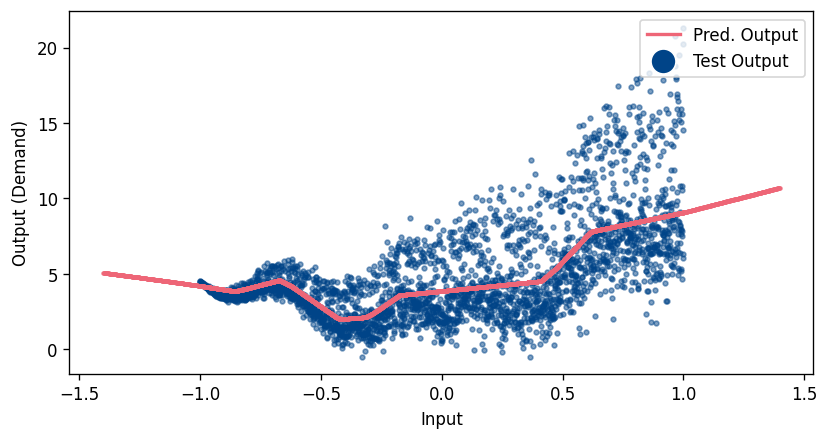

In [39]:
plot_regression(X, y, model_mse, 'ANN', '#EE6677', noise_type)

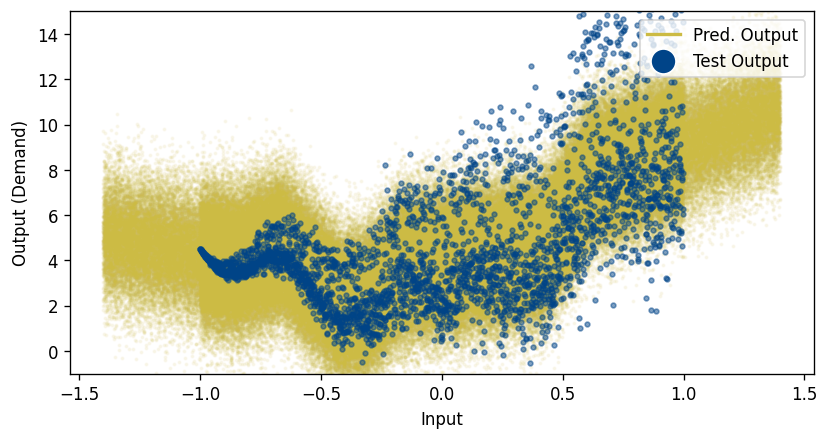

In [40]:
plot_regression(X, y, model_mse_noise, 'ANN_NOISE', '#CCBB44', noise_type)

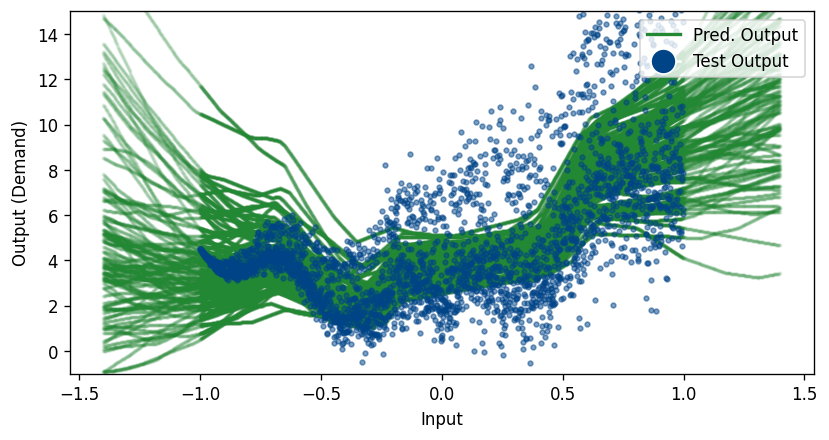

In [41]:
plot_regression(X, y, model_bnn_bayes, 'BNN', '#228833', noise_type)

In [61]:
y_pred_test = model_bnn_bayes.forward_dist(X)

In [74]:
y_pred_test[:, i, 0].detach().numpy()

(1000,)

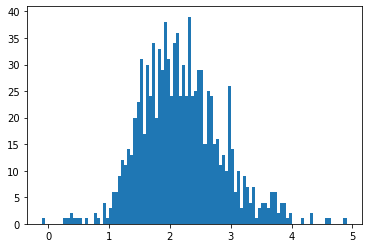

In [102]:
i = np.random.randint(0, 3000)
kkkkk = plt.hist(y_pred_test[:, i, 0].detach().numpy(), bins=100)

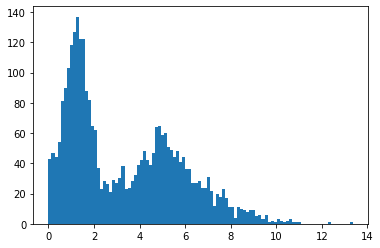

In [112]:
kkkkk = plt.hist(y[:3000,0].detach().numpy(), bins=100)

(3000,)

In [ ]:
'#EE3377', '#CC3311', '#EE7733'

In [159]:
def compute_nv_curve(X, y, model, M=1000):
    sell_price = 200
    dict_results_nr = {}
    for cost_price in (np.arange(0.1,0.9,0.03)*sell_price):
        quantile = (sell_price-cost_price)/sell_price
        dict_results_nr[quantile] = round(
            classical_newsvendor_utils.compute_norm_regret(
            X, y, model, M, sell_price, cost_price).item(), 
            3)
    return dict_results_nr

In [160]:
nr_ann = compute_nv_curve(X, y, model_mse, M=1000)
nr_ann_noise = compute_nv_curve(X, y, model_mse_noise, M=1000)
nr_bnn = compute_nv_curve(X, y, model_bnn_bayes, M=1000)

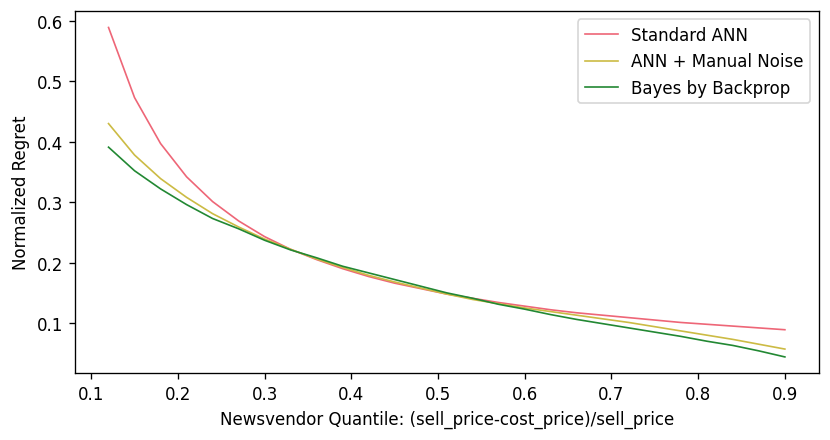

In [161]:
fig, ax = plt.subplots(figsize=(8, 4), dpi=120)
ax.plot(nr_ann.keys(), nr_ann.values(), color='#EE6677', label='Standard ANN', linewidth=1)
ax.plot(nr_ann_noise.keys(), nr_ann_noise.values(), color='#CCBB44', label='ANN + Manual Noise', linewidth=1)
ax.plot(nr_bnn.keys(), nr_bnn.values(), color='#228833', label='Bayes by Backprop', linewidth=1)
ax.legend()

ax.set_ylabel('Normalized Regret')
ax.set_xlabel('Newsvendor Quantile: (sell_price-cost_price)/sell_price')
fig.savefig('./figures/newsvendor_quantile_curve.png')